<a href="https://colab.research.google.com/github/Garaujott/Bootcamp_Data_Science_Alura/blob/main/Desafios/Modulo01/super_desafio_bootcamp_M1_leitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dinâmica da variação dos leitos existentes nos estados durante a pandemia do Coronavírus

O objetivo desse notebook é avaliar a dinâmica sob a qual a quantidade de leitos esteve sujeita durante a pandemia do coronavírus. Para isso, serão utilizados dados de leitos existentes.

Fonte dos dados:

1.   Quantidade de leitos existentes/SUS/não-SUS (01/2018 a 09/2021) - http://tabnet.datasus.gov.br/cgi/deftohtm.exe?cnes/cnv/leiintbr.def
2.   População Residente - Estimativas para o TCU (2001 a 2020) - https://www.ibge.gov.br/estatisticas/sociais/populacao/9103-estimativas-de-populacao.html?=&t=downloads


### Preparação do Ambiente

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

## Importar e preparar bases

In [5]:
leitos_ex = pd.read_csv('/content/quantidade_existente.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3, engine = 'python', skipfooter = 12)
leitos_sus = pd.read_csv('/content/quantidade_sus.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3, engine = 'python', skipfooter = 12)
leitos_nsus = pd.read_csv('/content/quantidade_nsus.csv', sep = ';', encoding = 'ISO-8859-1', skiprows = 3, engine = 'python', skipfooter = 12)
populacao = pd.read_excel('/content/serie_2001_2020_TCU.xls', skiprows = 4, skipfooter = 10)

### Limpeza da base de População
* problemas: 
  1. além dos dados por UFs, a base veio com dados agregados por região e a nível nacional. Há também uma linha de NaN, resultado da formatação do arquivo xlsx;
  2. os números de população foram lidos como float;
  3. padronizar nome da coluna das UFs para o nome utilizado pelas bases dos TabNet/DataSUS

* soluções: 
  1. deixar apenas UFs, apagando 'Brasil', regiões, NaN; 
  2. transformar float em int; 
  3. renomear a coluna 'Unidades da Federação' para 'Unidade da Federação'.

In [6]:
populacao.head() # antes

,Unidades da Federação,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Brasil,172385826.0,174632960.0,176871437.0,181581024.0,184184264.0,186770562.0,183989711.0,189612814.0,191480630.0,190747855.0,192379287.0,193946886.0,201032714.0,202768562.0,204450649.0,206081432.0,207660929.0,208494900.0,210147125.0,211755692.0
2,Região Norte,13245084.0,13504599.0,13784881.0,14373260.0,14698878.0,15022060.0,14623317.0,15142684.0,15359608.0,15880839.0,16095187.0,16318163.0,16983484.0,17231027.0,17472636.0,17707783.0,17936201.0,18182253.0,18430980.0,18672591.0
3,Rondônia,1407886.0,1431777.0,1455907.0,1562085.0,1534594.0,1562417.0,1453756.0,1493566.0,1503928.0,1560501.0,1576455.0,1590011.0,1728214.0,1748531.0,1768204.0,1787279.0,1805788.0,1757589.0,1777225.0,1796460.0
4,Acre,574355.0,586942.0,600595.0,630328.0,669736.0,686652.0,655385.0,680073.0,691132.0,732793.0,746386.0,758786.0,776463.0,790101.0,803513.0,816687.0,829619.0,869265.0,881935.0,894470.0


In [7]:
populacao.rename(mapper = {'Unidades da Federação': 'Unidade da Federação'}, axis = 1, inplace = True) # 3
populacao.set_index('Unidade da Federação', inplace = True)
populacao.dropna(axis = 0, how = 'all', inplace = True) # 1
populacao = populacao.astype(int) # 2
populacao.drop(labels = ['Brasil', 'Região Norte', 'Região Nordeste', 'Região Centro-Oeste', 'Região Sudeste', 'Região Sul'], inplace = True) # 1


In [8]:
populacao.head() # depois

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Unidade da Federação,,,,,,,,,,,,,,,,,,,,
Rondônia,1407886,1431777,1455907,1562085,1534594,1562417,1453756,1493566,1503928,1560501,1576455,1590011,1728214,1748531,1768204,1787279,1805788,1757589,1777225,1796460
Acre,574355,586942,600595,630328,669736,686652,655385,680073,691132,732793,746386,758786,776463,790101,803513,816687,829619,869265,881935,894470
Amazonas,2900240,2961801,3031068,3138726,3232330,3311026,3221940,3341096,3393369,3480937,3538387,3590985,3807921,3873743,3938336,4001667,4063614,4080611,4144597,4207714
Roraima,337237,346871,357302,381896,391317,403344,395725,412783,421499,451227,460165,469524,488072,496936,505665,514229,522636,576568,605761,631181
Pará,6341736,6453683,6574993,6850181,6970586,7110465,7065573,7321493,7431020,7603239,7688593,7792561,7969654,8073924,8175113,8272724,8366628,8513497,8602865,8690745


### Preparação base de leitos existentes - TabNet/DataSUS

Preparar bases do TabNet/DataSUS
* tirar o id do nome da UF
* dividir o número de leitos pela população de um dado ano

In [9]:
leitos_ex.head()

,Unidade da Federação,2018/Jan,2018/Fev,2018/Mar,2018/Abr,2018/Mai,2018/Jun,2018/Jul,2018/Ago,2018/Set,2018/Out,2018/Nov,2018/Dez,2019/Jan,2019/Fev,2019/Mar,2019/Abr,2019/Mai,2019/Jun,2019/Jul,2019/Ago,2019/Set,2019/Out,2019/Nov,2019/Dez,2020/Jan,2020/Fev,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set
0,11 Rondônia,4304,4325,4343,4343,4334,4337,4437,4425,4425,4395,4396,4407,4392,4459,4524,4558,4558,4548,4558,4507,4514,4429,4429,4252,4259,4286,4320,4345,4354,4431,4512,4537,4547,4566,4569,4586,4537,4533,4594,4637,4624,4607,4593,4671,4691
1,12 Acre,1452,1458,1459,1459,1459,1459,1459,1476,1476,1477,1426,1423,1412,1439,1443,1469,1490,1479,1483,1490,1478,1478,1476,1489,1484,1484,1498,1506,1559,1559,1602,1693,1677,1618,1613,1613,1623,1694,1710,1717,1659,1615,1601,1612,1585
2,13 Amazonas,5829,5735,5716,5762,5786,5789,5791,5752,5755,5784,5743,5810,5756,5798,5801,5807,5794,5740,5539,5607,5618,5608,5660,5684,5684,5700,5785,5970,6074,5972,5932,5884,5884,5884,5755,5897,5837,5922,6048,5992,6030,6023,6031,6043,6058
3,14 Roraima,941,941,934,1051,1052,1052,1052,1052,1069,1050,1050,1048,1048,1048,1048,1048,1048,1049,1067,1095,1085,1093,1093,1134,1133,1133,1213,1339,1515,1527,1527,1501,1490,1490,1490,1370,1553,1560,1510,1465,1217,1279,1277,1319,1319
4,15 Pará,15320,15257,15196,15235,15264,15242,15222,15223,15068,14798,14866,14868,14869,14734,14710,14606,14579,14490,14102,14094,14199,14175,14199,14188,13670,13584,13802,14623,14614,14888,15102,15368,15321,15374,15283,15267,15371,15315,15298,15244,15184,15185,15109,15096,15189


In [10]:
leitos_ex['Unidade da Federação'] = leitos_ex['Unidade da Federação'].str.slice(start = 3)
leitos_ex.set_index('Unidade da Federação', inplace = True)

In [11]:
leitos_ex.head()

,2018/Jan,2018/Fev,2018/Mar,2018/Abr,2018/Mai,2018/Jun,2018/Jul,2018/Ago,2018/Set,2018/Out,2018/Nov,2018/Dez,2019/Jan,2019/Fev,2019/Mar,2019/Abr,2019/Mai,2019/Jun,2019/Jul,2019/Ago,2019/Set,2019/Out,2019/Nov,2019/Dez,2020/Jan,2020/Fev,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Rondônia,4304,4325,4343,4343,4334,4337,4437,4425,4425,4395,4396,4407,4392,4459,4524,4558,4558,4548,4558,4507,4514,4429,4429,4252,4259,4286,4320,4345,4354,4431,4512,4537,4547,4566,4569,4586,4537,4533,4594,4637,4624,4607,4593,4671,4691
Acre,1452,1458,1459,1459,1459,1459,1459,1476,1476,1477,1426,1423,1412,1439,1443,1469,1490,1479,1483,1490,1478,1478,1476,1489,1484,1484,1498,1506,1559,1559,1602,1693,1677,1618,1613,1613,1623,1694,1710,1717,1659,1615,1601,1612,1585
Amazonas,5829,5735,5716,5762,5786,5789,5791,5752,5755,5784,5743,5810,5756,5798,5801,5807,5794,5740,5539,5607,5618,5608,5660,5684,5684,5700,5785,5970,6074,5972,5932,5884,5884,5884,5755,5897,5837,5922,6048,5992,6030,6023,6031,6043,6058
Roraima,941,941,934,1051,1052,1052,1052,1052,1069,1050,1050,1048,1048,1048,1048,1048,1048,1049,1067,1095,1085,1093,1093,1134,1133,1133,1213,1339,1515,1527,1527,1501,1490,1490,1490,1370,1553,1560,1510,1465,1217,1279,1277,1319,1319
Pará,15320,15257,15196,15235,15264,15242,15222,15223,15068,14798,14866,14868,14869,14734,14710,14606,14579,14490,14102,14094,14199,14175,14199,14188,13670,13584,13802,14623,14614,14888,15102,15368,15321,15374,15283,15267,15371,15315,15298,15244,15184,15185,15109,15096,15189


In [12]:
leitos_ex_soma_mensal = leitos_ex.sum(axis = 0)
leitos_ex_soma_mensal = leitos_ex_soma_mensal.rename('Total')
leitos_ex = leitos_ex.append(other = leitos_ex_soma_mensal)

In [13]:
leitos_ex.tail()

,2018/Jan,2018/Fev,2018/Mar,2018/Abr,2018/Mai,2018/Jun,2018/Jul,2018/Ago,2018/Set,2018/Out,2018/Nov,2018/Dez,2019/Jan,2019/Fev,2019/Mar,2019/Abr,2019/Mai,2019/Jun,2019/Jul,2019/Ago,2019/Set,2019/Out,2019/Nov,2019/Dez,2020/Jan,2020/Fev,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Mato Grosso do Sul,5588,5568,5620,5620,5611,5526,5528,5518,5492,5468,5506,5523,5569,5572,5575,5636,5608,5608,5624,5655,5644,5638,5617,5577,5611,5596,5691,5715,5711,5719,5766,5814,5815,5812,5783,5789,5789,5787,5770,5774,5683,5686,5763,5730,5752
Mato Grosso,7185,7202,7191,7304,7346,7317,7277,7257,7264,7248,7197,7241,7135,7133,7228,7155,7180,7206,7433,7236,7257,7325,7285,7261,7181,7156,7072,7058,7308,7304,7337,7226,7324,7241,7220,7211,7239,7261,7312,7340,7312,7350,7372,7391,7465
Goiás,17498,17717,17682,17681,17834,17912,18062,17791,17930,17777,17330,17451,17328,17306,17421,17444,17357,17219,17199,17087,17151,17262,17413,17358,17502,17445,17666,17747,17784,17880,18022,18177,18152,18164,17965,18305,18290,18386,18526,18409,18340,18423,18564,18708,18778
Distrito Federal,6742,6716,6748,6523,6583,6781,6875,6733,6594,6561,6737,6737,6979,6979,7053,7382,7417,7280,7339,7219,7191,7130,6951,6631,6715,6705,6851,6840,7106,7345,7355,7317,7364,7528,7609,7739,7748,7504,7512,7592,7675,7663,7686,7703,7675
Total,437565,438234,438005,436824,437355,437251,438243,437529,437335,432281,432086,432788,433223,433686,433971,434505,434345,433570,432803,432157,432805,432399,431928,430602,426106,426388,433574,441811,446503,448923,450599,449941,449984,448573,446960,447804,447359,447510,449720,450004,449844,448858,449282,449552,449442


## Pontos de análise

### Qual é o lag temporal desde o primeiro caso/óbito confirmado de Covid e uma variação expressiva no número de leitos?

Primeiro caso confirmado no país: 26/02/2020, São Paulo. (https://www.unasus.gov.br/noticia/coronavirus-brasil-confirma-primeiro-caso-da-doenca)

Primeiro óbito confirmado no país: 12/03/2020, São Paulo. (https://g1.globo.com/bemestar/coronavirus/noticia/2020/06/27/primeira-morte-por-coronavirus-no-brasil-aconteceu-em-12-de-marco-diz-ministerio-da-saude.ghtml)

Vamos plotar um gráfico para verificarmos isso!

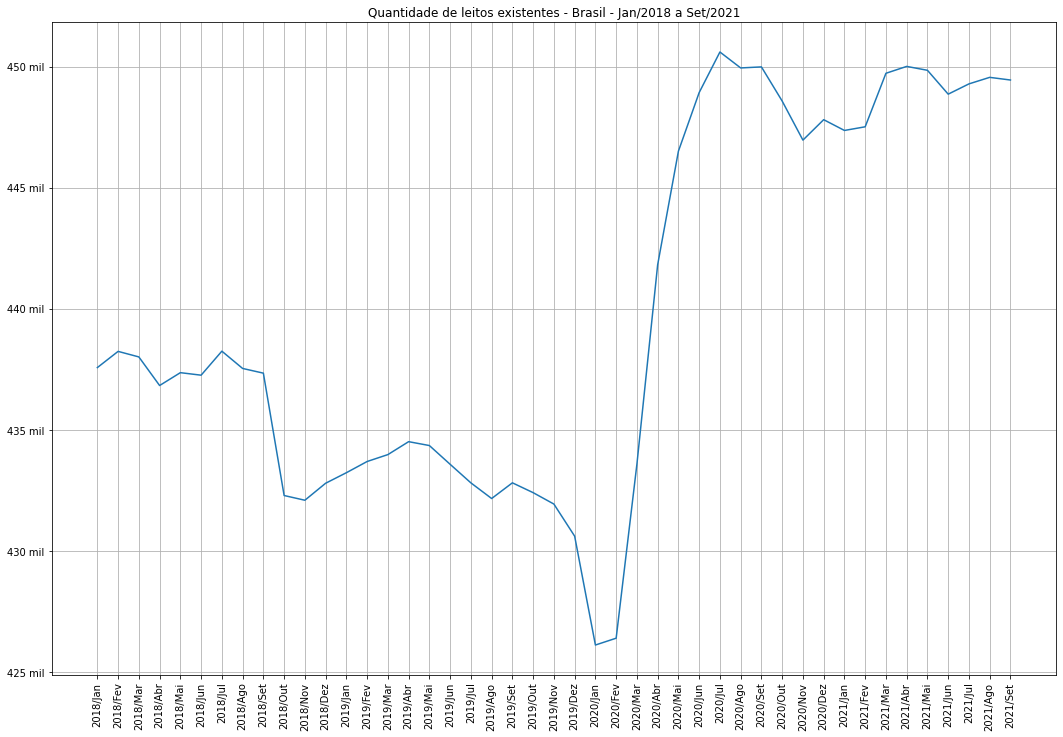

In [14]:
leitos_exT_div1000 = leitos_ex.T/1000
ax = leitos_exT_div1000.plot(y = 'Total', legend = None, figsize = (18,12), grid = True)
colunas = leitos_ex.columns.to_list()
plt.xticks(ticks = range(0, len(colunas)), labels = colunas, rotation = 90)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f} mil'))
plt.title("Quantidade de leitos existentes - Brasil - Jan/2018 a Set/2021")
plt.show()

A partir do gráfico, podemos ver que já a partir dos primeiros casos confirmados em março de 2020, houve crescimento no número de leitos até julho do mesmo ano. Interessante ver também que com a desaceleração da pandemia a partir da setembro, houve uma queda entre os meses de setembro e novembro de 2020.

Portanto, podemos dizer que não houve defasagem entre os primeiros casos e uma resposta na quantidade de leitos existentes pelo menos a nível nacional. Provavelmente muito por conta da instalação de hospitais de campanha por parte dos municípios e estados. O estado de São Paulo por exemplo chegou a contar com 56 hospitais de campanha. (https://www.tce.sp.gov.br/6524-56-hospitais-campanha-implantados-estado-35-permanecem-ativos)

### Como se deu a variação percentual de leitos a partir de março no país?

In [15]:
leitos_exT_perc = leitos_ex.T.pct_change() * 100 # deixar em %
leitos_exT_perc.tail(10)

Unidade da Federação,Rondônia,Acre,Amazonas,Roraima,Pará,Amapá,Tocantins,Maranhão,Piauí,Ceará,Rio Grande do Norte,Paraíba,Pernambuco,Alagoas,Sergipe,Bahia,Minas Gerais,Espírito Santo,Rio de Janeiro,São Paulo,Paraná,Santa Catarina,Rio Grande do Sul,Mato Grosso do Sul,Mato Grosso,Goiás,Distrito Federal,Total
2020/Dez,0.372073,0.000000,2.467420,-8.053691,-0.104691,-1.129032,2.042206,0.094118,0.286212,-0.076550,1.054120,0.797043,0.187986,-2.971327,-0.393224,0.201444,-0.117409,-1.416928,1.135424,0.056530,-0.150992,0.000000,-0.049894,0.103752,-0.124654,1.892569,1.708503,0.188831
2021/Jan,-1.068469,0.619963,-1.017467,13.357664,0.681208,-0.978793,0.000000,0.523877,-0.421889,-1.001021,1.602850,1.787761,0.109089,-0.367478,-0.364409,0.043558,0.171619,-0.114475,-1.021854,-0.416804,-0.234032,-0.286197,0.119804,0.000000,0.388296,-0.081945,0.116294,-0.099374
2021/Fev,-0.088164,4.374615,1.456228,0.450741,-0.364322,2.141680,0.000000,0.247211,0.336449,0.061907,-0.450732,1.159649,-0.039229,0.583986,-2.224931,0.281332,0.281631,-0.598497,-1.445365,0.558779,0.054134,0.645793,-0.721290,-0.034548,0.303909,0.524877,-3.149200,0.033754
2021/Mar,1.345687,0.944510,2.127660,-3.205128,-0.111002,8.064516,0.166778,1.586244,0.049677,0.773355,0.327003,0.222593,-0.061047,-2.352941,1.589776,0.494289,0.461045,1.101717,0.698363,0.421546,1.424758,1.212003,-0.646177,-0.293762,0.702383,0.761449,0.106610,0.493844
2021/Abr,0.936003,0.409357,-0.925926,-2.980132,-0.352987,5.298507,0.166500,0.314919,-0.037239,1.258570,-0.802307,-0.022210,-0.475588,0.156470,0.797791,0.518445,-0.093184,2.850988,-1.725477,0.580902,0.224048,-0.813268,-0.124684,0.069324,0.382932,-0.631545,1.064963,0.063150
2021/Mai,-0.280354,-3.377985,0.634179,-16.928328,-0.393597,-3.047484,0.299202,-0.863309,-0.024835,-0.747777,-1.415392,-0.322115,0.626918,0.015623,0.365297,-0.446340,0.123583,0.936307,1.041608,0.275073,-0.117096,0.561689,-0.307038,-1.576030,-0.381471,-0.374817,1.093256,-0.035555
2021/Jun,-0.367647,-2.652200,-0.116086,5.094495,0.006586,-0.438596,0.000000,0.501385,0.000000,-0.137447,0.307653,0.156006,-0.405176,0.781006,0.485290,-0.142805,-0.281795,1.000854,-1.234809,0.174471,-2.010729,-0.706215,-0.382442,0.052789,0.519694,0.452563,-0.156352,-0.219187
2021/Jul,-0.303885,-0.866873,0.132824,-0.156372,-0.500494,2.202643,0.563474,-1.175003,-0.335362,-0.305857,0.856230,0.990209,-0.192476,0.000000,0.452762,0.033258,0.063058,0.217523,0.721297,0.088133,-0.181271,0.181042,-0.071346,1.354203,0.299320,0.765348,0.300144,0.094462
2021/Ago,1.698236,0.687071,0.198972,3.288958,-0.086041,0.502874,1.845748,-0.059781,0.423729,0.639157,-0.747592,0.583893,0.280505,0.247985,1.081731,0.162910,-0.217062,0.542626,-0.036509,-0.227475,-0.835361,0.684136,0.078197,-0.572618,0.257732,0.775695,0.221181,0.060096
2021/Set,0.428174,-1.674938,0.248221,0.000000,0.616057,0.000000,0.000000,-0.465240,0.074460,0.289605,0.382995,-0.295728,0.393357,-0.015461,-0.802616,-0.398314,-0.063155,0.215879,-0.064616,-0.446532,0.296671,0.384615,0.098519,0.383944,1.001218,0.374171,-0.363495,-0.024469


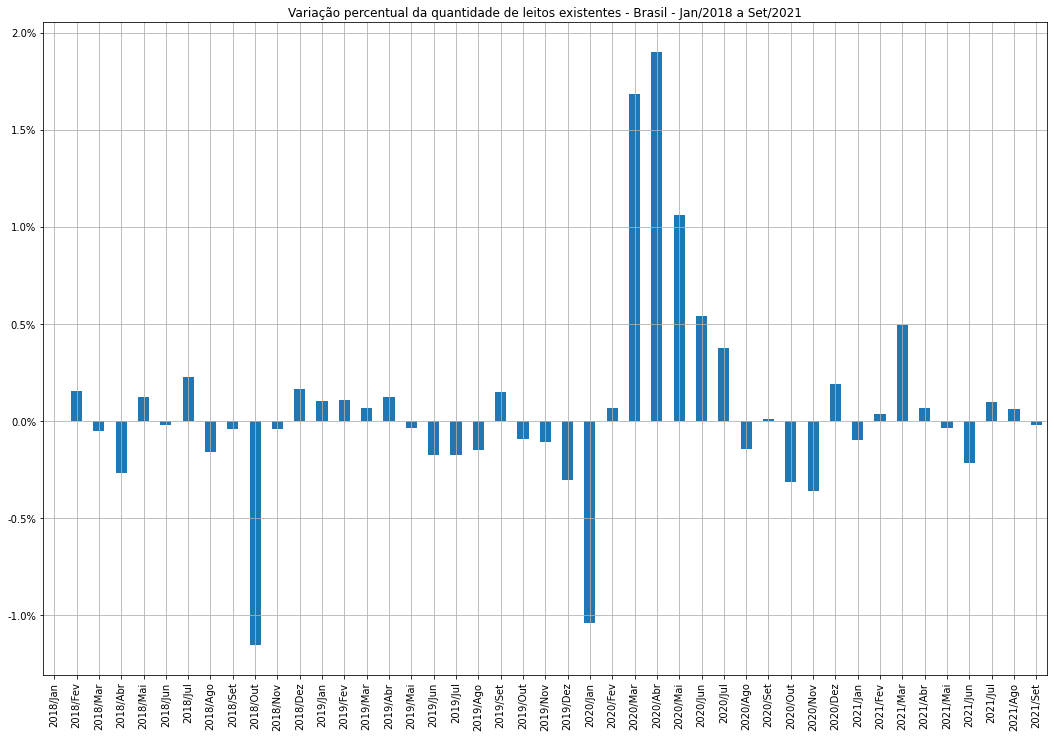

In [16]:
ax = leitos_exT_perc.plot(y = 'Total', kind = 'bar', legend = None, figsize = (18,12), grid = True)
colunas = leitos_ex.columns.to_list()
plt.xticks(ticks = range(0, len(colunas)), labels = colunas, rotation = 90)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}%'))
plt.title("Variação percentual da quantidade de leitos existentes - Brasil - Jan/2018 a Set/2021")
plt.show()

Aqui fica ainda mais claro o que foi relatado anteriormente. Entre março e julho de 2020, houve um grande crescimento no número de leitos no país. Enquanto nos meses de desaceleração da pandemia, houve um decrescimento do número. É possível supor também que o aumento de 0.5% em março de 2021 esteja relacionado ao recrudescimento da pandemia devido à variante Delta, fazendo com que os hospitais de campanha fosse reativados.

### E em São Paulo?

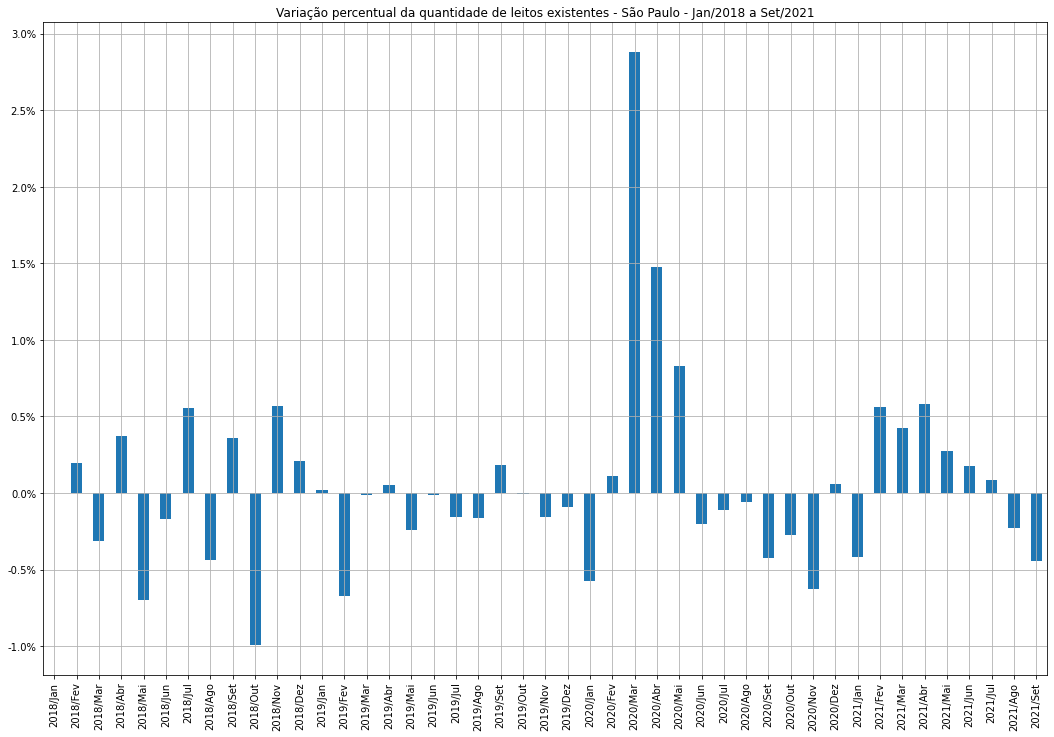

In [17]:
ax = leitos_exT_perc.plot(y = 'São Paulo', kind = 'bar', legend = None, figsize = (18,12), grid = True)
colunas = leitos_ex.columns.to_list()
plt.xticks(ticks = range(0, len(colunas)), labels = colunas, rotation = 90)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}%'))
plt.title("Variação percentual da quantidade de leitos existentes - São Paulo - Jan/2018 a Set/2021")
plt.show()

Diferentemente de quando analisamos todo o país, vemos que o período de crescimento de leitos no início da pandemia foi mais curto em comparação com o país inteiro. Por outro lado, o aumento de leitos durante a segunda onda se deu de forma mais consistente quando consideramos o aumento em todo o país.

### E no Amazonas?

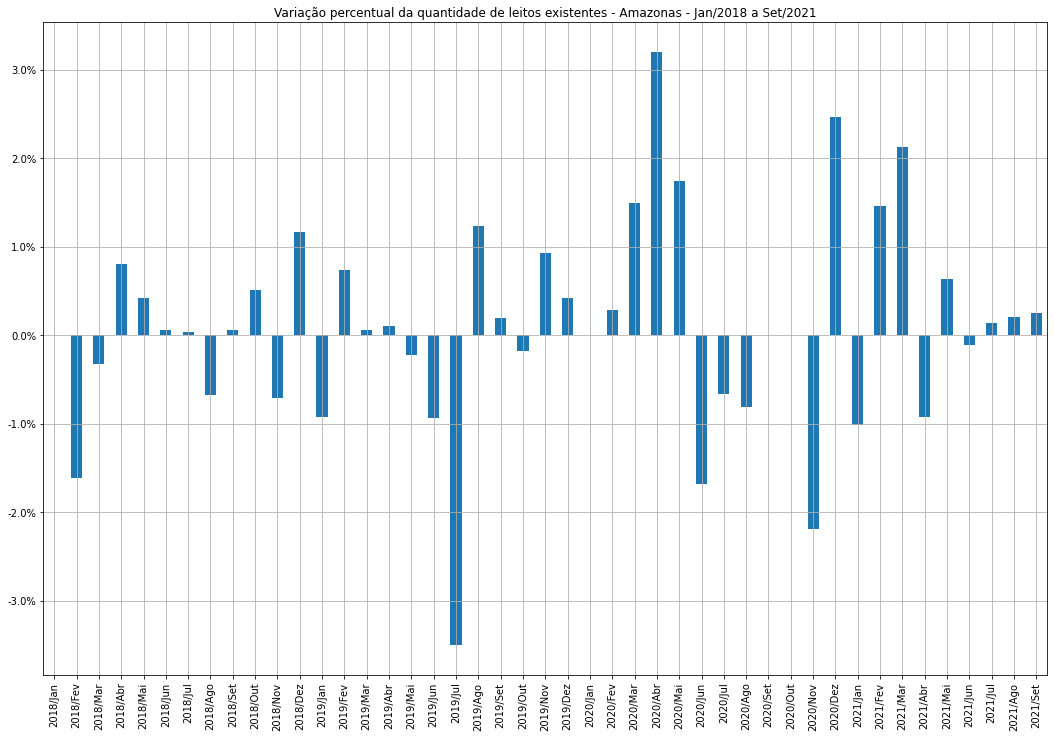

In [18]:
ax = leitos_exT_perc.plot(y = 'Amazonas', kind = 'bar', legend = None, figsize = (18,12), grid = True)
colunas = leitos_ex.columns.to_list()
plt.xticks(ticks = range(0, len(colunas)), labels = colunas, rotation = 90)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}%'))
plt.title("Variação percentual da quantidade de leitos existentes - Amazonas - Jan/2018 a Set/2021")
plt.show()

A quantidade de leitos existentes no estado do Amazonas seguiu uma dinâmica turbulenta. Após 3 meses de aumento do número de leitos no início da pandemia, sucedeu-se 6 meses de variação negativa ou estabilidade. Até que em dezembro de 2020 e nos meses seguintes, a quantidade de leitos voltou a aumentar provavelmente devido à disseminação da variante Delta.

### Quais outras unidades da federação poderiamos considerar?

#### Maior e menor média? (Roraima e Rio de Janeiro)

In [19]:
leitos_exT_perc.mean().sort_values(ascending = False)

Unidade da Federação
Roraima                0.892409
Amapá                  0.522293
Tocantins              0.349307
Distrito Federal       0.313304
Ceará                  0.216084
Acre                   0.214430
Rondônia               0.201186
Espírito Santo         0.197966
Pernambuco             0.180626
Goiás                  0.163800
Paraíba                0.142054
Maranhão               0.138840
Piauí                  0.136851
Rio Grande do Norte    0.120543
Sergipe                0.118755
Amazonas               0.094708
Mato Grosso            0.092677
Minas Gerais           0.076739
Mato Grosso do Sul     0.067741
Total                  0.062170
Santa Catarina         0.060213
São Paulo              0.056063
Bahia                  0.052722
Alagoas                0.032821
Paraná                 0.009404
Pará                  -0.010881
Rio Grande do Sul     -0.111497
Rio de Janeiro        -0.124473
dtype: float64

#### Maior e menor desvio padrão? (Roraima e Rio Grande do Sul)

In [20]:
leitos_exT_perc.std().sort_values(ascending = False)

Unidade da Federação
Roraima                4.998004
Amapá                  3.361502
Distrito Federal       1.936280
Rio de Janeiro         1.922407
Alagoas                1.894352
Sergipe                1.844179
Acre                   1.761050
Pernambuco             1.339336
Pará                   1.337688
Tocantins              1.298902
Amazonas               1.204440
Rio Grande do Norte    1.114287
Mato Grosso            1.088424
Piauí                  1.051016
Rondônia               1.038792
Espírito Santo         1.027969
Maranhão               0.852174
Goiás                  0.810316
Paraíba                0.744819
Ceará                  0.728774
Minas Gerais           0.639042
Mato Grosso do Sul     0.636389
São Paulo              0.625965
Santa Catarina         0.588455
Paraná                 0.539115
Total                  0.514085
Bahia                  0.435163
Rio Grande do Sul      0.379121
dtype: float64

### E no Rio de Janeiro?

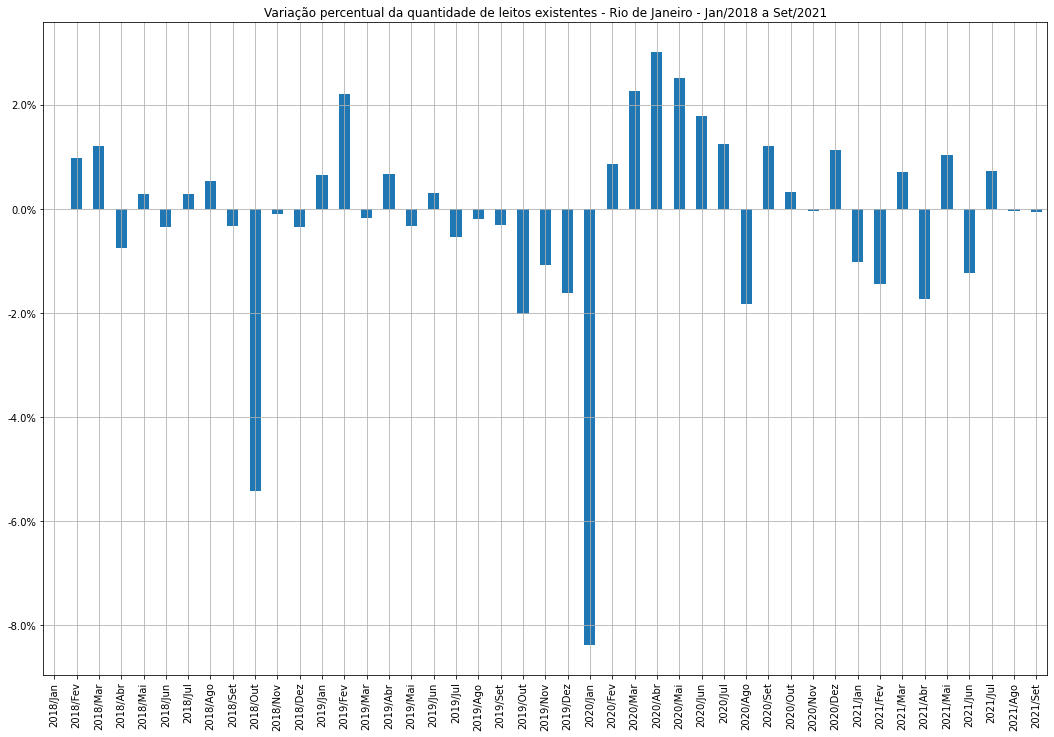

In [26]:
ax = leitos_exT_perc.plot(y = 'Rio de Janeiro', kind = 'bar', legend = None, figsize = (18,12), grid = True)
colunas = leitos_ex.columns.to_list()
plt.xticks(ticks = range(0, len(colunas)), labels = colunas, rotation = 90)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}%'))
plt.title("Variação percentual da quantidade de leitos existentes - Rio de Janeiro - Jan/2018 a Set/2021")
plt.show()

O que mais chama a atenção no Rio de Janeiro é que nos meses anteriores à pandemia houve diversas reduções no número de leitos no estado. Porém, com uma rápida pesquisa, encontra-se a razão disso. O estado passa por uma crise de saúde desde antes da pandemia, o que pode explicar esse movimento de redução. 

(https://www1.folha.uol.com.br/cotidiano/2019/09/rj-adoece-com-crises-na-saude-municipal-estadual-e-federal.shtml; https://noticias.uol.com.br/cotidiano/ultimas-noticias/2019/12/14/crise-no-saude-rio-tem-188-mil-pacientes-graves-na-fila-por-atendimento.htm)

### E no Rio Grande do Sul?

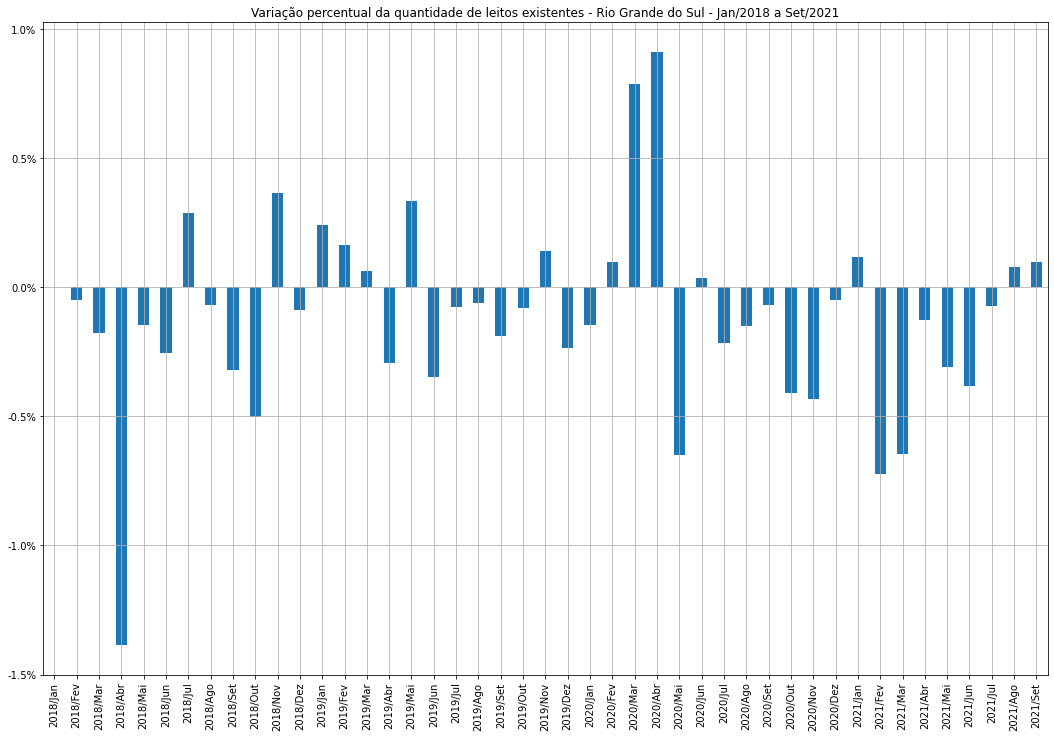

In [24]:
ax = leitos_exT_perc.plot(y = 'Rio Grande do Sul', kind = 'bar', legend = None, figsize = (18,12), grid = True)
colunas = leitos_ex.columns.to_list()
plt.xticks(ticks = range(0, len(colunas)), labels = colunas, rotation = 90)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}%'))
plt.title("Variação percentual da quantidade de leitos existentes - Rio Grande do Sul - Jan/2018 a Set/2021")
plt.show()

No Rio Grande do Sul, vemos que a quantidade de leitos no estado se manteve aproximadamente constante, sendo as variações percentuais pequenas em comparação com outros estados. O que explica tanto o fato do estado possuir uma das menores variações médias e o menor desvio padrão dentre as variações.

### E em Roraima?

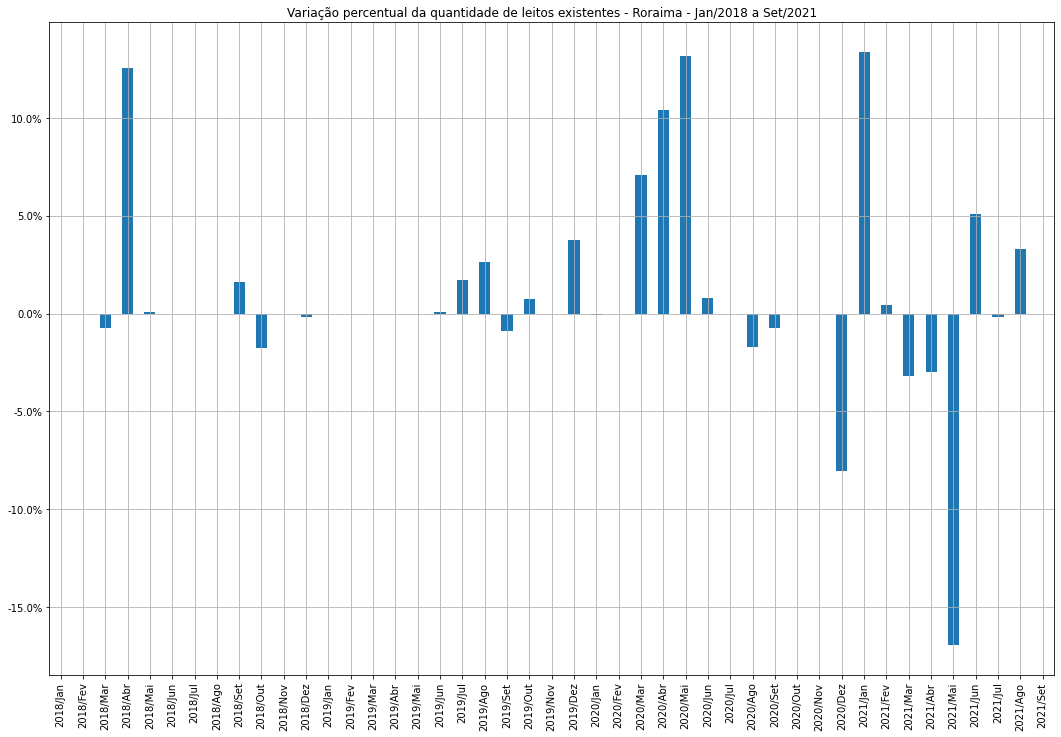

In [21]:
ax = leitos_exT_perc.plot(y = 'Roraima', kind = 'bar', legend = None, figsize = (18,12), grid = True)
colunas = leitos_ex.columns.to_list()
plt.xticks(ticks = range(0, len(colunas)), labels = colunas, rotation = 90)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.1f}%'))
plt.title("Variação percentual da quantidade de leitos existentes - Roraima - Jan/2018 a Set/2021")
plt.show()

Para falarmos sobre Roraima, é importante trazermos os dados absolutos de leitos desse estado.

In [23]:
leitos_ex.T[['Roraima']].T

,2018/Jan,2018/Fev,2018/Mar,2018/Abr,2018/Mai,2018/Jun,2018/Jul,2018/Ago,2018/Set,2018/Out,2018/Nov,2018/Dez,2019/Jan,2019/Fev,2019/Mar,2019/Abr,2019/Mai,2019/Jun,2019/Jul,2019/Ago,2019/Set,2019/Out,2019/Nov,2019/Dez,2020/Jan,2020/Fev,2020/Mar,2020/Abr,2020/Mai,2020/Jun,2020/Jul,2020/Ago,2020/Set,2020/Out,2020/Nov,2020/Dez,2021/Jan,2021/Fev,2021/Mar,2021/Abr,2021/Mai,2021/Jun,2021/Jul,2021/Ago,2021/Set
Unidade da Federação,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Roraima,941,941,934,1051,1052,1052,1052,1052,1069,1050,1050,1048,1048,1048,1048,1048,1048,1049,1067,1095,1085,1093,1093,1134,1133,1133,1213,1339,1515,1527,1527,1501,1490,1490,1490,1370,1553,1560,1510,1465,1217,1279,1277,1319,1319


Levando em consideração os dados absolutos do estado, podemos compreender melhor porque Roraima consta como o estado com a maior variação média e com o maior desvio padrão. Isso se deve ao fato de Roraima ser o estado com o menor número de leitos do país. Assim, qualquer alteração tem um alto efeito, principalmente ao compararmos essa variação com estados com mais leitos como São Paulo. Uma observação importante é Roraima saiu de 1133 leitos no período pré-pandemia para 1560 leitos em fevereiro de 2021, representando um aumento de cerca de 27%.

## Conclusões e extensões

Observando os gráficos da variação percentual de leitos no país e da variação percentual dos leitos por estado, podemos dizer que existem diversas dinâmicas dentro do país no que diz respeito à resposta de cada estado a pandemia. Um caso curioso é do Rio de Janeiro, que nos 5 meses anteriores ao início da pandemia em março de 2020 teve 4 meses de fortes quedas no número de leitos. Outro é o caso de Roraima que teve um aumento de cerca de 27% no número de leitos ao compararmos o momento pré-pandemia e durante a pandemia, equanto a maioria dos estados tem números bem mais modestos.

Porém, ao considerarmos apenas os números absolutos, esbarramos em alguns problemas como passarmos a impressão de que Roraima foi o estado que mais investiu em medidas contra a Covid por ter o maior crescimento percentual no número de leitos. Isso não é verdade, dado que SP teve um aumento de mais de 4000 leitos frente aos cerca de 430 leitos abertos por Roraima no mesmo período. De modo que apenas ter o maior crescimento percentual do número de leitos não garante, por exemplo, que o estado teve o maior investimento em medidas contra Covid.

Isso reforça a ideia de que essa análise, em termos absolutos, talvez não seja a mais adequada. Como solução para esse problema, poderiamos padronizar as medidas a partir da população de cada estado, criando então uma variável de leitos por mil habitantes e a partir daí, repetirmos as análises.

Três extensões interessantes: a primeira seria justamente refazer as análises considerando os dados em termos populacionais, enquanto a segunda seria verificar qual foi a influência do número de leitos nos óbitos em cada estado, considerando também outras características do estado. Isso poderia ser feito através de um modelo de regressão linear ou então algum modelo de séries temporais. Por fim, uma terceira extensão seria tentar entender os movimentos acontecidos em alguns estados como é o caso do Rio de Janeiro, citado acima.